# SRCNN：テスト結果
### テスト用画像、推定画像、劣化画像(BICUBIC縮小拡大やJPEG圧縮処理後データ)の表示  

## (A) BICUBIC劣化画像でのSRCNNモデル評価  
**BICUBIC拡大縮小画像を学習対象として、SRCNNの基本性能を確認**  

## (B) JPEG圧縮に関する評価  
**JPEG圧縮＋BICUBIC拡大縮小画像を学習対象として、提案モデルの性能を確認**  

## (C) まとめ  

**環境設定**

In [1]:
import os,sys
from pathlib import Path
from IPython.display import display

import argparse
parser = argparse.ArgumentParser(description='prediction')
parser.add_argument('--cuda', action='store_true', default=False)
parser.add_argument('--weight_path', type=str, default=None)
parser.add_argument('--save_dir', type=str, default="result/test")
if Path(sys.argv[0]).stem == 'ipykernel_launcher':
    # On IPython
    args=[]
    args.extend(["--weight_path","result/SRCNN/latest_weight.pth"])
    args.extend(["--save_dir","result/test"])
    # args.extend(["--cuda"])
    opt = parser.parse_args(args=args)
else:
    opt = parser.parse_args()
os.makedirs(opt.save_dir,exist_ok=True)

# Import model and def from training ipython
from ipynb.fs.full.train import *

## (A) BICUBIC劣化画像でのSRCNNモデル評価

### テストデータロード

In [2]:
test_set = DatasetLoader4Eval(image_dir='./data/General-100/test', scale_factor=4,comp=False)
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)

### テスト実行関数

In [3]:
def display3(No):
    # Image No.50
    # No = 50
    image3 = []
    for ty in ['hr','sr','lr']:
        image3.append(Image.open("{}/im_{}_{}.png".format(opt.save_dir, No, ty)))
    sys.stdout.flush()
    imageX3 = get_concat_h(* image3)
    display(imageX3)

def test(model, criterion, test_loader, save_dir, cuda=False):
    model.eval()
    total_loss, total_psnr = 0, 0
    total_loss_b, total_psnr_b = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch[0], batch[1]
            if cuda:
                inputs = inputs.cuda()
                targets = targets.cuda()

            prediction = model(inputs)
            loss = criterion(prediction, targets)
            total_loss += loss.data
            total_psnr += 10 * log10(1 / loss.data)

            loss = criterion(inputs, targets)
            total_loss_b += loss.data
            total_psnr_b += 10 * log10(1 / loss.data)

            filename = batch[2][0]
            save_image(prediction, Path(save_dir)/'{}_sr.png'.format(filename), nrow=1)
            save_image(inputs    , Path(save_dir)/'{}_lr.png'.format(filename), nrow=1)
            save_image(targets   , Path(save_dir)/'{}_hr.png'.format(filename), nrow=1)

    print("===> [DEGRADE] Avrg Loss: {:.4f} PSNR: {:.4f} dB".format(total_loss_b / len(test_loader), total_psnr_b / len(test_loader)))
    print("===> [RESTORE] Avrg Loss: {:.4f} PSNR: {:.4f} dB".format(total_loss / len(test_loader), total_psnr / len(test_loader)))

### モデルインスタンス関数

In [4]:
def loadmodel(model_name, weight_path, cuda=False):
    model = None
    if model_name == 'SRCNN':
        model = SRCNN()
    elif model_name == 'SRCNN11':
        model = SRCNN11()
    elif model_name == 'SYM':
        model = SYM()
    assert model is not None,"Unknown name {}".format(model_name)
    criterion = nn.MSELoss()
    model.load_state_dict(torch.load(weight_path, map_location='cuda' if opt.cuda else 'cpu'))
    if cuda:
        model = model.cuda()
        criterion = criterion.cuda()
    return model, criterion

### テスト実行と結果表示

In [5]:
def get_concat_h(im1, im2, im3):
    dst = Image.new('RGB', (im1.width + im2.width + im3.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    dst.paste(im3, (im1.width + im2.width, 0))
    return dst
def ptitle(degrade_type=' '):
    print("Original",' '*15,"Prediction",' '*13, "Degrade by "+degrade_type)

===> [DEGRADE] Avrg Loss: 0.0028 PSNR: 27.4851 dB
===> [RESTORE] Avrg Loss: 0.0021 PSNR: 29.1096 dB
SRCNN Trained by BICUBIC
Original                 Prediction               Degrade by BICUBIC


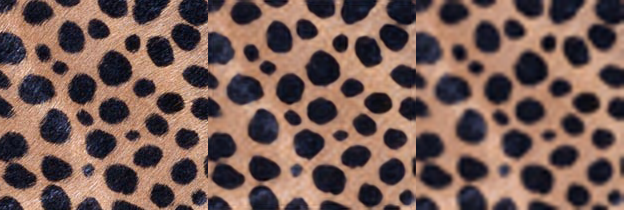

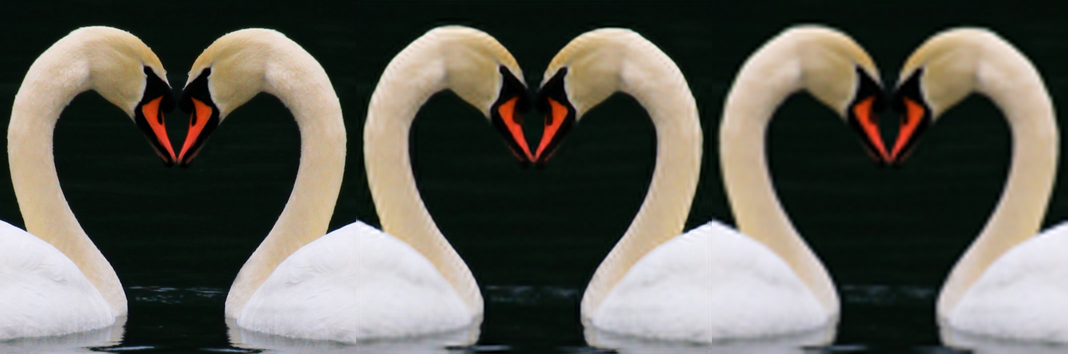

In [6]:
# Run test
model, criterion = loadmodel('SRCNN', 'result/SRCNN/latest_weight.pth')
test(model,criterion,test_loader,opt.save_dir)
print('SRCNN Trained by BICUBIC')
ptitle("BICUBIC")
display3(50)
display3(6)

# 結果
**テスト用画像に対しBICUBICによる劣化処理を行い、データ拡張の効果と参照論文モデルの基本性能を確認できた。**  

## (B) JPEG圧縮に関する評価：JPEG圧縮データでの学習無し
**学習した画像劣化方式(BICUBIC)以外の劣化方式についてSRCNNモデルでの超解像を用いる  
(DatasetLoader4Eval内で)元画像へBICUBIC劣化とJPEG圧縮を適用し、推論を行う  
JPEG圧縮はOpenCVのimencode処理をQuality=10にて行う**  

In [7]:
# comp = True means JPEG Compression
test_set = DatasetLoader4Eval(image_dir='./data/General-100/test', scale_factor=4,comp=True)
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)

===> [DEGRADE] Avrg Loss: 0.0041 PSNR: 24.7589 dB
===> [RESTORE] Avrg Loss: 0.0039 PSNR: 24.9100 dB
SRCNN Trained by BICUBIC
Original                 Prediction               Degrade by BICBIC+JPEG


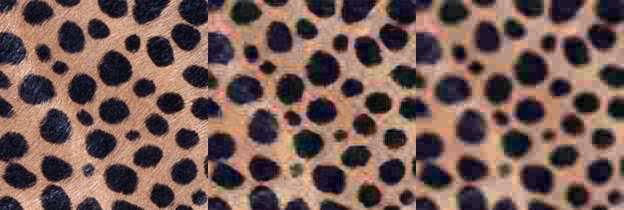

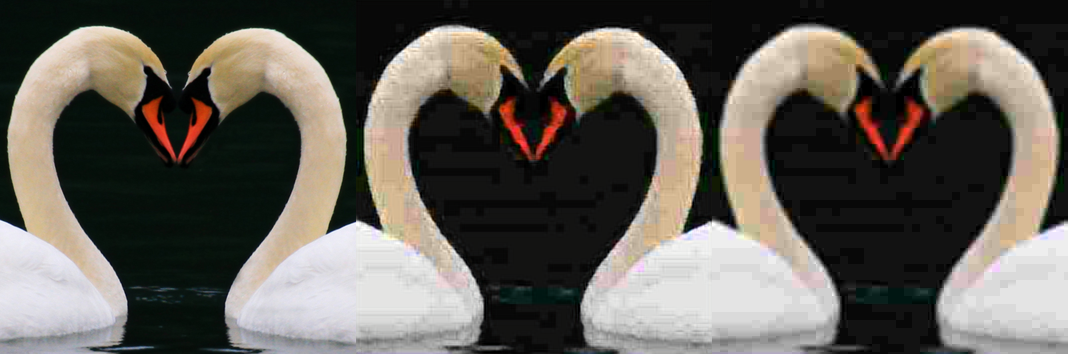

In [8]:
# Run test with BICUBIC and JPEG

model, criterion = loadmodel('SRCNN', 'result/SRCNN/latest_weight.pth')
test(model,criterion,test_loader,opt.save_dir)

print('SRCNN Trained by BICUBIC')
ptitle("BICBIC+JPEG")
display3(50)
display3(6)

## (B) JPEG圧縮に関する評価：JPEG圧縮データでの学習あり
**BICUBIC並びにJPEG圧縮後の画像を学習したSRCNNモデルで超解像を行う**  

In [9]:
# comp = True means JPEG Compression
test_set = DatasetLoader4Eval(image_dir='./data/General-100/test', scale_factor=4,comp=True)
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)

===> [DEGRADE] Avrg Loss: 0.0041 PSNR: 24.7589 dB
===> [RESTORE] Avrg Loss: 0.0033 PSNR: 25.7507 dB
SRCNN Trained by BICUBIC+JPEG
Original                 Prediction               Degrade by BICBIC+JPEG


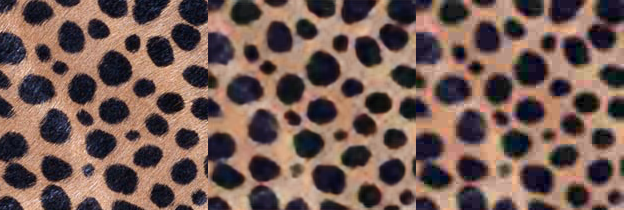

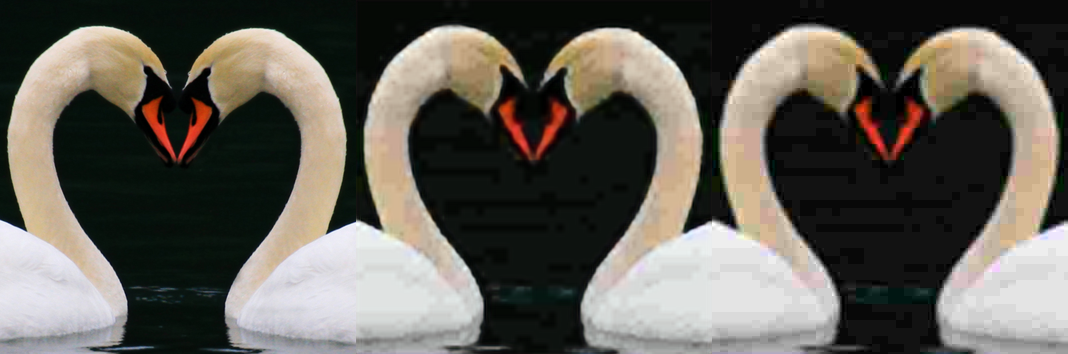

In [10]:
# Run test with BICUBIC and JPEG

model, criterion = loadmodel('SRCNN','result-comp10/SRCNN/latest_weight.pth')
test(model,criterion,test_loader,opt.save_dir)

print('SRCNN Trained by BICUBIC+JPEG')
ptitle("BICBIC+JPEG")
display3(50)
display3(6)

## (B) JPEG圧縮に関する評価：JPEG圧縮データでの学習あり SRCNN11モデル
**BICUBIC並びにJPEG圧縮後の画像を学習したSRCNN11モデルで超解像を行う**  
特徴抽出層のカーネルサイズ9x9に11x11の特徴抽出層を追加：SRCNN11モデル

In [11]:
# comp = True means JPEG Compression
test_set = DatasetLoader4Eval(image_dir='./data/General-100/test', scale_factor=4,comp=True)
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)

===> [DEGRADE] Avrg Loss: 0.0041 PSNR: 24.7589 dB
===> [RESTORE] Avrg Loss: 0.0033 PSNR: 25.7704 dB
SRCNN11 Trained by BICUBIC+JPEG
Original                 Prediction               Degrade by BICBIC+JPEG


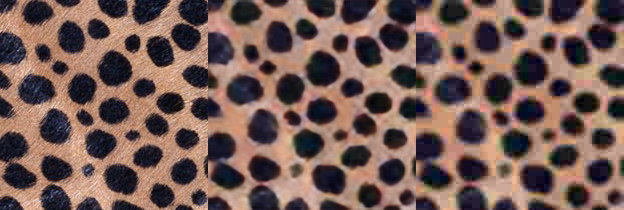

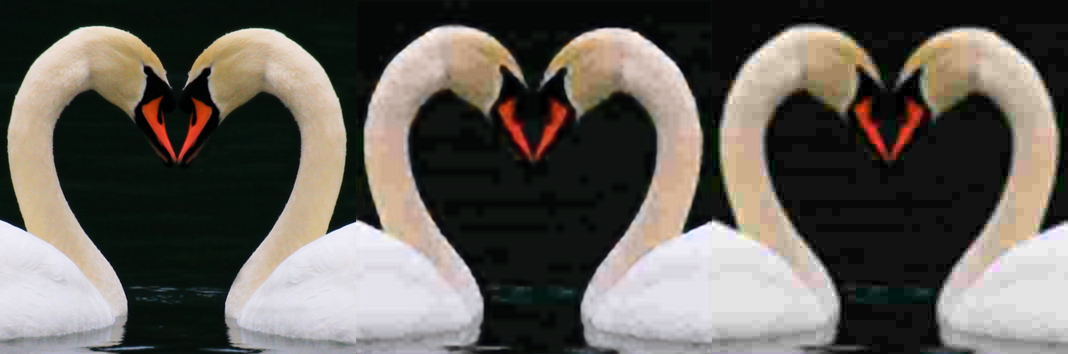

In [12]:
# Run test with BICUBIC and JPEG

model, criterion = loadmodel('SRCNN11','result-comp10/SRCNN-c11/latest_weight.pth')
test(model,criterion,test_loader,opt.save_dir)
print('SRCNN11 Trained by BICUBIC+JPEG')
ptitle("BICBIC+JPEG")
display3(50)
display3(6)

## (B) JPEG圧縮に関する評価：JPEG圧縮データでの学習あり SYMモデル
**BICUBIC並びにJPEG圧縮後の画像を学習したSYMモデルで超解像を行う**  
SRCNNに残差機構を追加し、低層の情報を上位層へ直接伝えると共に、勾配消失を回避:SYMモデル

In [13]:
# comp = True means JPEG Compression
test_set = DatasetLoader4Eval(image_dir='./data/General-100/test', scale_factor=4,comp=True)
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)

===> [DEGRADE] Avrg Loss: 0.0041 PSNR: 24.7589 dB
===> [RESTORE] Avrg Loss: 0.0030 PSNR: 26.4734 dB
SYM Trained by BICUBIC+JPEG
Original                 Prediction               Degrade by BICBIC+JPEG


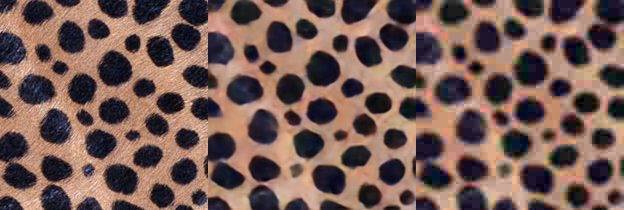

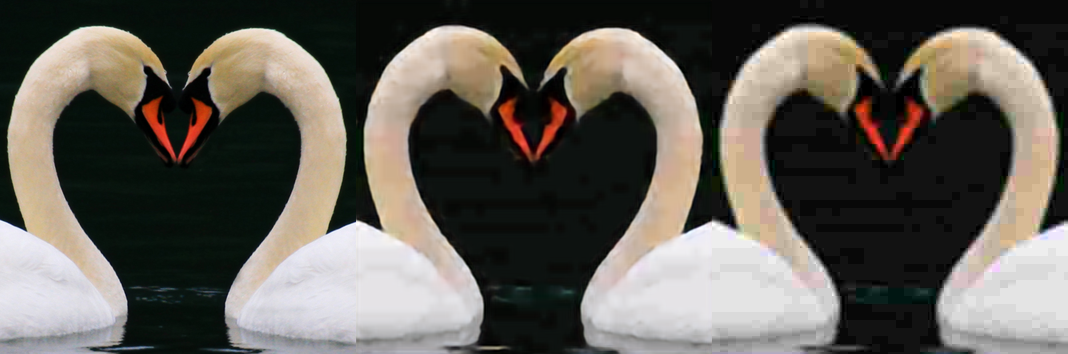

In [14]:
# Run test with BICUBIC and JPEG

model, criterion = loadmodel('SYM','result-comp10/SRCNN-sym/latest_weight.pth')
test(model,criterion,test_loader,opt.save_dir)

print('SYM Trained by BICUBIC+JPEG')
ptitle("BICBIC+JPEG")
display3(50)
display3(6)

## (C) まとめ  

### 比較サマリー及び考察
　**劣化画像(Degraded)を基準として、各モデルでの改善量(Gain)を表にまとめた**  

| Model  |PSNR(dB) |Gain(dB)|memo               |  
|-       |-        |-       |-                  |  
|Degraded| 24.7589 |-       |Standard           |  
|SRCNN   | 24.9100 |0.1511  |BICUBIC Only Train |  
|SRCNN   | 25.7507 |0.9918  |BICUBIC+JPEG Train |  
|SRCNN11 | 25.7704 |1.0115  |BICUBIC+JPEG Train |  
|SYM     | 26.4734 |1.7145  |BICUBIC+JPEG Train |

　**上記の通り、BICUBIC縮小拡大＋JPEG圧縮した画像の学習を行うことにより、両劣化方式に対応したモデルが達成できた。また提案モデル拡張により改善量を大きくすることができた。ただし不可逆画像圧縮方法として各種あり、それらを全て網羅しているわけではないことは言うまでもない。**  

　**圧縮画像での評価に関して、見た目の改善とPSNRとの関連について注意する必要がある。同位置のピクセル同士でRGBの差分を比較するPSNRと、人間が綺麗になったと感じることとは異なる。人間は、画像内容物の形が1ピクセルズレても綺麗に感じることに変わりがないが、PSNR比較では改善量が小さくなる。**  

### 今後の課題  
　**2016以降、超解像モデルの教師無し学習が提案されてきているが、GANを応用する教師無し学習モデルなどでは、特定の画像劣化方式に対する依存性が下がり、少なくとも画像の悪化問題などの改善や超解像の汎用化が期待でき、今後適用実験を行いたい。ただし、5層のSYMに対して、GANなどの演算量は非常に大きく、またレイテンシも伸びる傾向にある。FPGAやSoCへの搭載などリアルタイム性を考慮するケースでは改善量とのトレードオフが必要と考える。**  